# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig136


# Flo's original approach:
7. Two-state design: 
`/home/flop/switch/5thround/DHRs/msd7/msd_scripts/` has the scripts



# I need to add a few things to Flo's method.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

TODO sequence recovery of parent as a final metric in 05?  
TODO explore `FavorSequenceProfile` instead of `FavorNativeResidue`

# Make functions for looping and labeling to assist downstream penultimate design step

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose

def linkres_msd(packed_pose_in=None, **kwargs) -> PackedPose:
    """Load pose. Design with linkres x3: state_X_nocys, state_Y_nocys,
    state_XY_nocys. Dump all 3 poses in kwarg output_path during method.
    """
    from copy import deepcopy
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed import cluster
    from pyrosetta.rosetta.protocols.denovo_design.movers import FastDesign
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects
    from pyrosetta.rosetta.protocols.task_operations import LinkResidues
    from pyrosetta.rosetta.core.pack.task.operation import (
        IncludeCurrent,
        InitializeFromCommandline,
        ExtraRotamersGeneric,
    )
    from pyrosetta.rosetta.protocols.task_operations import (
        LimitAromaChi2Operation
    )
    
    if packed_pose_in == None:
        pdb_path = kwargs["-s"]
    else:
        raise RuntimeError("This method requires a pdb path, it cannot accept a PackedPose as input")
    scores = cluster.get_scores_dict(pdb_path)["scores"]
    ppose = io.pose_from_file(pdb_path)
    pose = io.to_pose(ppose)
    if kwargs["out_path"] == None:
        out_path = os.getcwd()
    else: 
        out_path = kwargs["out_path"]
        os.makedirs(os.path.join(os.getcwd(), out_path), exist_ok=True)
    cys_X = scores["disulfide_at_X"].split(",")
    cys_Y = scores["disulfide_at_Y"].split(",")
    unique_cys = set(cys_X + cys_Y)
    # check whether disulfides are orthogonal
    design_resis = [int(x) for x in unique_cys]
    if len(unique_cys) < 3 or len(unique_cys) > 4: # if there are less than 3 CYS or more than 4 we really f'd up at some point
        raise RuntimeError("There should be at least 3 unique CYS, but no more than 4")
    else:
        cys1_X, cys2_X = int(cys_X[0]), int(cys_X[1])
        cys1_Y, cys2_Y = int(cys_Y[0]), int(cys_Y[1])
    length = scores["total_length"]
    resis_matrix = [[x, int(x+length)] for x in design_resis]
    target_resis = ",".join([str(x) for row in resis_matrix for x in row]) # flatten matrix
    xml_string = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn_design" weights="{sfxn}" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Index name="designable" resnums="{target_resis}" />
            <Neighborhood name="packable" selector="designable" distance="6.0" include_focus_in_subset="true" />
            <Not name="not_designable" selector="designable" />
            <Not name="not_packable" selector="packable" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <OperateOnResidueSubset name="design" selector="designable"> # no CYS; GLY; PRO; TRP
                <RestrictAbsentCanonicalAASRLT aas="ADEFHIKLMNQRSTVY" />
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="pack" selector="not_designable">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="lock" selector="not_packable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <MOVERS>
            <SwitchChainOrder name="delete_Y" chain_order="1"/>
            <SwitchChainOrder name="delete_X" chain_order="2"/>
            <MutateResidue name="cys1_X" target="{cys1_X}" new_res="CYS" />
            <MutateResidue name="cys2_X" target="{cys2_X}" new_res="CYS" />
            <MutateResidue name="cys1_Y" target="{cys1_Y}" new_res="CYS" />
            <MutateResidue name="cys2_Y" target="{cys2_Y}" new_res="CYS" />
            <ForceDisulfides name="restore_X" 
                scorefxn="sfxn_design"
                disulfides="{cys1_X}:{cys2_X}"
                remove_existing="false"
                repack="true" />
            <ForceDisulfides name="restore_Y" 
                scorefxn="sfxn_design"
                disulfides="{cys1_Y}:{cys2_Y}"
                remove_existing="false"
                repack="true" />
            <FastRelax name="relax" 
                scorefxn="sfxn_design"
                repeats="2" 
                relaxscript="MonomerRelax2019"
                />
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        sfxn=scores["sfxn_used"],
        target_resis=target_resis,
        cys1_X=cys1_X,
        cys2_X=cys2_X,
        cys1_Y=cys1_Y,
        cys2_Y=cys2_Y,
    )
    # link all designable residues
    linkres = LinkResidues()
    for row in resis_matrix:
        linkres.add_group(",".join([str(x) for x in row]))
    # set taskops by extracting them from the xml_string
    xml_obj = XmlObjects.create_from_string(xml_string)
    design_task = xml_obj.get_task_operation("design")
    pack_task = xml_obj.get_task_operation("pack")
    lock_task = xml_obj.get_task_operation("lock")
    # set taskops
    task_factory = pyrosetta.rosetta.core.pack.task.TaskFactory()
    task_factory.push_back(IncludeCurrent())
    task_factory.push_back(InitializeFromCommandline())
    arochi = LimitAromaChi2Operation()
    arochi.include_trp(True)
    task_factory.push_back(arochi)
    ex1_ex2 = ExtraRotamersGeneric()
    ex1_ex2.ex1(True); ex1_ex2.ex2(True)
    task_factory.push_back(ex1_ex2)
    task_factory.push_back(design_task)
    task_factory.push_back(pack_task)
    task_factory.push_back(lock_task)
    task_factory.push_back(linkres)
    # set movemap
    mm = pyrosetta.rosetta.core.kinematics.MoveMap()
    mm.set_bb(False)
    mm.set_chi(True)
    mm.set_jump(False)
    sfxn_design = xml_obj.get_score_function("sfxn_design")
    fast_design = FastDesign(scorefxn_in=sfxn_design, standard_repeats=1)
    fast_design.cartesian(False)
    fast_design.set_task_factory(task_factory)
    fast_design.set_movemap(mm)
    fast_design.minimize_bond_angles(False)
    fast_design.minimize_bond_lengths(False)
    fast_design.min_type("lbfgs_armijo_nonmonotone")
    fast_design.ramp_down_constraints(False)
    
    name = pose.pdb_info().name()
    basename_no_ext = name.split("/")[-1].replace(".pdb", "", 1)
    if out_path[-1] != "/":
        out_path += "/"
    else:
        pass
    pose = pose.clone()
    fast_design.apply(pose)
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_XY.pdb")) 
    
    ref_pose = pose.clone()
    # get state X
    delete_Y = xml_obj.get_mover("delete_Y")
    delete_Y.apply(pose)
    ref_X = pose.clone()
    cys1 = xml_obj.get_mover("cys1_X")
    cys2 = xml_obj.get_mover("cys2_X")
    restore = xml_obj.get_mover("restore_X")
    relax = xml_obj.get_mover("relax")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_X.pdb")) 
    # get rmsd
    relax_X = ref_X.clone()
    relax.apply(relax_X)
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_X)
    rmsd = rmsd_calc.calculate(relax_X)
    scores["rmsd_final_X"] = rmsd
    # get state Y
    pose = ref_pose.clone()
    delete_X = xml_obj.get_mover("delete_X")
    delete_X.apply(pose)
    ref_Y = pose.clone()
    cys1 = xml_obj.get_mover("cys1_Y")
    cys2 = xml_obj.get_mover("cys2_Y")
    restore = xml_obj.get_mover("restore_Y")
    relax = xml_obj.get_mover("relax")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_Y.pdb")) 
    # get rmsd
    relax_Y = ref_Y.clone()
    relax.apply(relax_Y)
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_Y)
    rmsd = rmsd_calc.calculate(relax_Y)
    scores["rmsd_final_Y"] = rmsd
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(ref_pose, key, value)
#     pyrosetta.rosetta.core.pose.setPoseExtraScore(ref_pose, "basename_no_ext", basename_no_ext) #TODO
    ppose = io.to_packed(ref_pose)
    return ppose

In [3]:
# flags = """
# -multithreading:total_threads 4
# -quasisymmetry 1
# -corrections::beta_nov16 true
# -detect_disulf false
# -holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
# -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
# """
# import pyrosetta
# pyrosetta.init(" ".join(flags.replace("\n\t", " ").split()))
# t = linkres_msd("05_selected/tj/good_trp/2021.03.08.22.24.53.141698_5f14d50d11534d65bd713dca7bf0226d.pdb", out_path="test")


# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000`  
if you"re using a local cluster make sure the node this notebook is on has the same 
number of workers as cores

TODO, force stdout to go into logs
TODO `extra=["--lifetime", "170m", "--lifetime-stagger", "4m"]`

In [4]:
!echo $HOSTNAME
!echo $USER

dig136
pleung


In [5]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    cores=1,
    processes=1,
    job_cpu=1,
    local_directory="$TMPDIR/dask",
    log_directory="/mnt/home/pleung/logs/slurm_logs",
    memory="8GB",
    queue="medium",
    walltime="23:58:00",
    death_timeout=600,
)
print(cluster.job_script())
# scale between 0 and 1000 workers as needed
cluster.adapt(minimum=0, maximum=1020, wait_count=999) 
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:58:00

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.240:38091 --nthreads 1 --memory-limit 8.00GB --name name --nanny --death-timeout 600 --local-directory $TMPDIR/dask



Client Scheduler: tcp://172.16.131.240:38091 Dashboard: http://172.16.131.240:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client
Try `tj` to start

In [ ]:
import logging
from pyrosetta.distributed.cluster.core import PyRosettaCluster
logging.basicConfig(level=logging.INFO)

pdbs = glob(os.path.join(os.getcwd(), "05_selected/tj/good_trp/*.pdb"))

options = { 
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-quasisymmetry": "true",
    "-detect_disulf": "false",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

def create_tasks(pdbs, options):
    for pdb_path in pdbs:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["-s"] = pdb_path
        tasks["out_path"] = "06_states"
        tasks["set_logging_handler"] = "interactive"
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "06_cleanup")
    PyRosettaCluster(
        tasks=create_tasks(pdbs, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
    ).distribute(protocols=[linkres_msd])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}


https://docs.anaconda.com/anaconda/install



INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Now do nocys

In [ ]:
import logging
from pyrosetta.distributed.cluster.core import PyRosettaCluster
logging.basicConfig(level=logging.INFO)

pdbs = glob(os.path.join(os.getcwd(), "05_selected/nocys/good_trp/*.pdb"))

options = { 
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-quasisymmetry": "true",
    "-detect_disulf": "false",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

def create_tasks(pdbs, options):
    for pdb_path in pdbs:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["-s"] = pdb_path
        tasks["out_path"] = "06_states"
        tasks["set_logging_handler"] = "interactive"
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "06_cleanup_nocys")
    PyRosettaCluster(
        tasks=create_tasks(pdbs, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
    ).distribute(protocols=[linkres_msd])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



# Look at scores
There is certainly a less embarrassing way to do this but at least this way is vectorized, so it should scale very well

In [3]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "06_cleanup")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,abegos_X,abegos_Y,approximate_buried_unsat_penalty,bb_clash,buns_X,buns_Y,closure_type_X,closure_type_Y,disulfide_at_X,disulfide_at_Y,...,total_length,total_score,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_cleanup/decoys/0000/2021.03.17.22.02.34.624929_eb33d2234469448fa60c30453a4011fa.pdb.bz2,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,58.0,11060.885742,5.0,3.0,original,strict_remodel,"81,130","88,130",...,192.0,-316.907996,-792.036560,-778.134644,0.0,0.0,0.474766,0.750335,0.102174,0.127562
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_cleanup/decoys/0000/2021.03.17.22.02.34.624929_0636205f36674384b386b49053c9b7ee.pdb.bz2,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,60.0,56.123001,3.0,7.0,original,strict_remodel,"81,130","86,137",...,192.0,-230.645859,-787.921814,-781.199158,0.0,0.0,0.400544,0.510983,0.091544,0.131511
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_cleanup/decoys/0000/2021.03.17.22.02.34.624929_9706aaf3a5cc4a36a3206209975c5ed4.pdb.bz2,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,58.0,11060.885742,4.0,6.0,original,strict_remodel,"81,130","88,130",...,192.0,-284.063906,-778.232056,-749.931396,0.0,0.0,0.563643,0.941632,0.104406,0.113277
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_cleanup/decoys/0000/2021.03.17.22.02.34.624929_5c4417a56af1433faef75e5524a14872.pdb.bz2,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,61.0,10822.755859,3.0,5.0,original,strict_remodel,"81,130","68,116",...,192.0,-188.860709,-799.627869,-751.319702,0.0,0.0,0.550680,0.885171,0.120981,0.141395
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_cleanup/decoys/0000/2021.03.17.22.02.34.624929_f7ba630921534e51b6d80eca03a63b6d.pdb.bz2,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAABBBAAAAAAAAAAAAAAAAAAAAAAA...,55.5,10822.755859,3.0,3.0,original,strict_remodel,"81,130","68,116",...,192.0,-316.810177,-793.901672,-748.268616,0.0,1.0,0.505676,1.268920,0.093341,0.149642


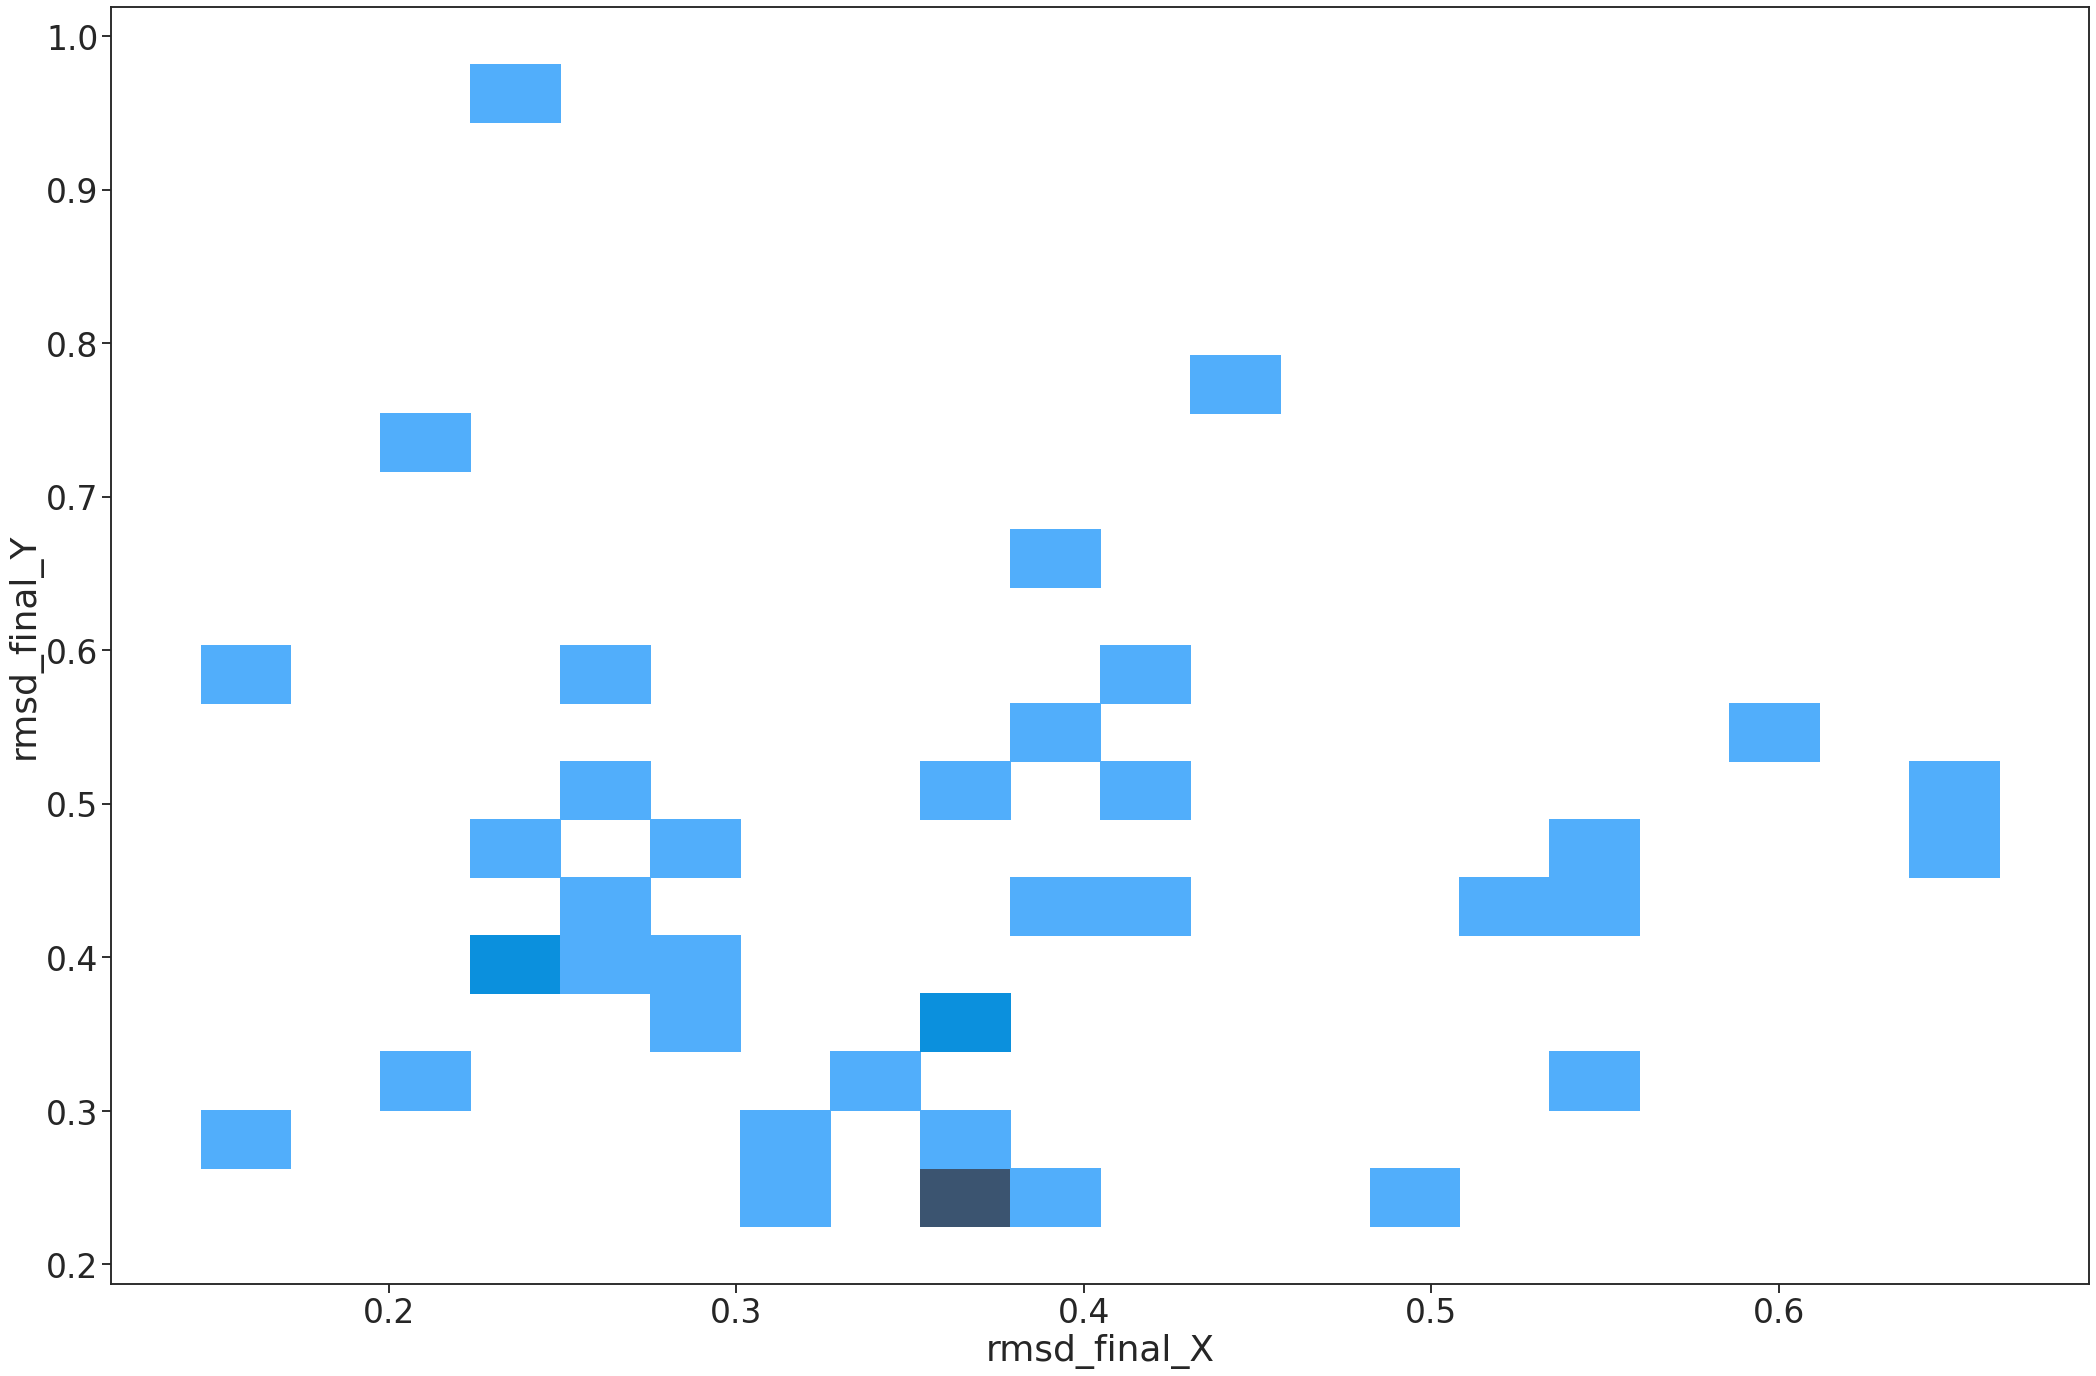

In [9]:
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)

fig = plt.figure(figsize=(30,20), tight_layout=True)
sns.histplot(x="rmsd_final_X", y="rmsd_final_Y", data=scores_df, bins=20)
fig.savefig("figs/06_rmsd_final.png")


In [10]:
no_explode = scores_df[(scores_df.rmsd_final_X <= 0.6) & (scores_df.rmsd_final_Y <= 0.6)]
len(no_explode)

36

In [38]:
import pyrosetta
pyrosetta.distributed.init()
import pyrosetta.distributed.io as io
from pyrosetta.distributed import cluster

final_pdbs = glob(os.path.join(os.getcwd(), "06_states/*XY.pdb"))
to_inspect = []
with open("final_to_inspect.list", "w+") as f:
    for pdb in final_pdbs:
        basename_no_ext = pdb.split("_XY")[0]
        decoys = list(no_explode.index)
        for decoy in decoys:
            decoy_basename = cluster.get_scores_dict(decoy)["instance"]["tasks"]["-s"].split("/")[-1].replace(".pdb", "")
            if decoy_basename in basename_no_ext:
                decoys.remove(decoy)
                print(pdb.replace("X", "", 1), file=f)

In [49]:
os.makedirs("06_to_order", exist_ok=True)
tag = "GHHHHHHGS"
all_id = {}
with open("final_to_inspect.list", "r") as f:
    with open("06_to_order/all.fasta", "w+") as out:
        for i, line in enumerate(f):
            all_id[f"pf_{i}"] = f"{line.rstrip()}"
            print(f">pf_{i}", file=out)
            print(tag+io.pose_from_file(line.rstrip()).pose.sequence(), file=out)
all_id

{'pf_0': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_018487d85448435ca5a39dcf684aba6d_Y.pdb',
 'pf_1': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_5a28ccf4f05148479b48562ed2a419ab_Y.pdb',
 'pf_2': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_3e5d1e2bbaf4423c87baf7b831f63c68_Y.pdb',
 'pf_3': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_5d3c1ea5239f45d4b31f88bc284b1581_Y.pdb',
 'pf_4': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_8a78b774678047b7ab1e8409de147255_Y.pdb',
 'pf_5': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_5f14d50d11534d65bd713dca7bf0226d_Y.pdb',
 'pf_6': '/mnt/home/pleung/projects/bistable_bundle/r3/hinges/06_states/2021.03.08.22.24.53.141698_c77c043413c34f8bbcdab1089e970a8d_Y.pdb',
 'pf_7': '/mnt/home/

In [52]:
import json
with open("06_to_order/all_ids.json", "w+") as f:
    print(json.dumps(all_id), file=f)

In [53]:
test = json.loads("06_to_order/all_ids.json")
test


JSONDecodeError: Extra data: line 1 column 2 (char 1)